Virtual env to execute:
```
conda create -n DL_phd_py39 seaborn numpy pandas scikit-plot scipy=1.11.4 pydot jupyter python=3.9
conda activate DL_phd_py39
pip install tensorflow==2.17
python3 -m pip install tensorflow[and-cuda]
```

if necessary:


Create symbolic links to NVIDIA shared libraries:

```
pushd $(dirname $(python -c 'print(__import__("tensorflow").__file__)'))
ln -svf ../nvidia/*/lib/*.so* .
popd
```
Create a symbolic link to ptxas:
```
ln -sf $(find $(dirname $(dirname $(python -c "import nvidia.cuda_nvcc;         
print(nvidia.cuda_nvcc.__file__)"))/*/bin/) -name ptxas -print -quit) $VIRTUAL_ENV/bin/ptxas
```

Verify the GPU setup:
```
python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
```

In [1]:
import pandas as pd
import numpy as np
import operator
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# #definindo o path para executar no LOCAL
path = "/home/pedro/projetoDL/dataset/processado/"
log_path_tmp = "/home/pedro/projetoDL/log"
# definindo o path para log com timestamp
log_path = log_path_tmp + "/exp_" + timestamp + ""

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 20 12:43:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:07:00.0  On |                  N/A |
|  0%   53C    P5             28W /  170W |    1270MiB /  12288MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU está conectada")
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        print(f"Nome da GPU: {gpu.name}")
else:
    print("Não conectado a uma GPU")

2024-11-03 17:05:06.443851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 17:05:06.454760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 17:05:06.457987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 17:05:06.466812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 17:05:07.050753: W tensorflow/compiler/tf2

GPU está conectada
Nome da GPU: /physical_device:GPU:0


I0000 00:00:1730664307.576139   22439 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730664307.597249   22439 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730664307.600646   22439 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Tensorflow version: ", tf.__version__)

import scipy
print(f"SciPy version: {scipy.__version__}")

import scikitplot as skplt
print(f"scikit-plot version: {skplt.__version__}")

GPU is available
Tensorflow version:  2.17.0
SciPy version: 1.11.4
scikit-plot version: 0.3.7


In [5]:
Y = np.load(path + 'Y_train_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_train_NewApproach_Injected_v2.npz')
X = X.f.arr_0

In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
#import scikitplot as skplt
import matplotlib.pyplot as plt
from numpy import interp

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.

    Argumento(s):
    history -- Objeto retornado pela função fit do keras.

    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.savefig("ks_plot.png")
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

In [7]:
import gc

# Garbage collector para liberar memória RAM.
gc.collect()

0

/home/pedro/miniconda3/envs/DL_phd_py39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730664311.863273   22439 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730664311.868376   22439 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730664311.8721

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 44, 116, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 116, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,306,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,233 (5.19 MB)

 Trainable params: 1,359,041 (5.18 MB)

 Non-trainable params: 192 (768.00 B)

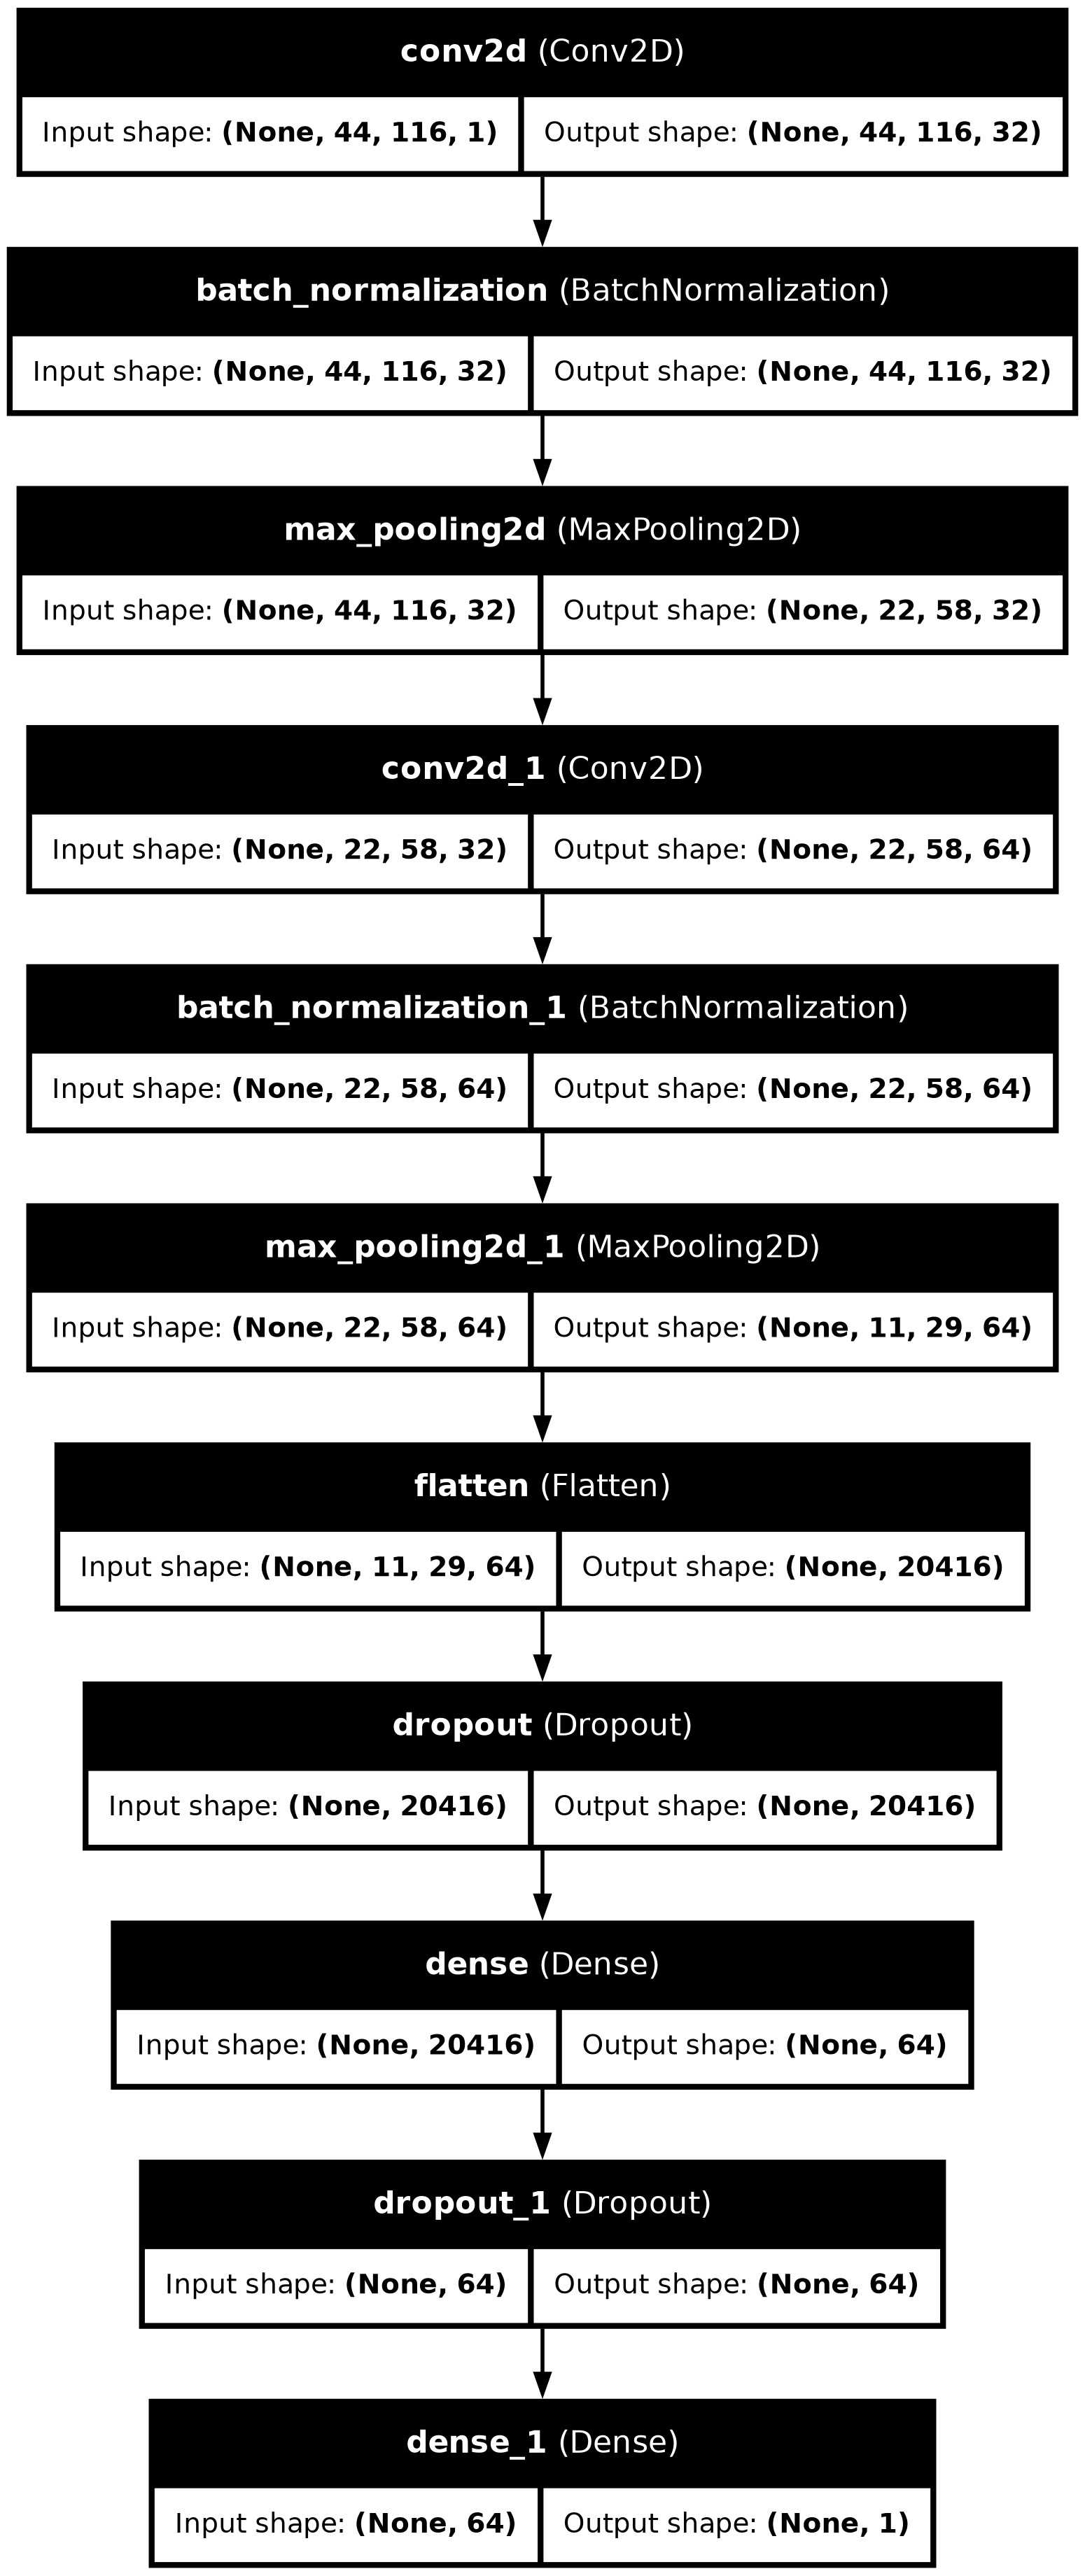

------------------------------------------------------------------------
Epoch 1/30


I0000 00:00:1730664315.470877   22606 service.cc:146] XLA service 0x7d1714005680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730664315.470896   22606 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-03 17:05:15.499521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-03 17:05:15.660917: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   4/2011 ━━━━━━━━━━━━━━━━━━━━ 1:06 33ms/step - accuracy: 0.6225 - loss: 4.6163

I0000 00:00:1730664321.188523   22606 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2011/2011 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.7464 - loss: 0.7757 - val_accuracy: 0.9931 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 2/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - accuracy: 0.9838 - loss: 0.0548 - val_accuracy: 0.9955 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 3/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.9961 - loss: 0.0309 - val_accuracy: 0.9961 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 4/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.9970 - loss: 0.0251 - val_accuracy: 0.9983 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 5/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.9974 - loss: 0.0240 - val_accuracy: 0.9967 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 6/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9979 - loss: 0.0221 - val_accuracy: 0.9962 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 7/30
2010/2011 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9980 -

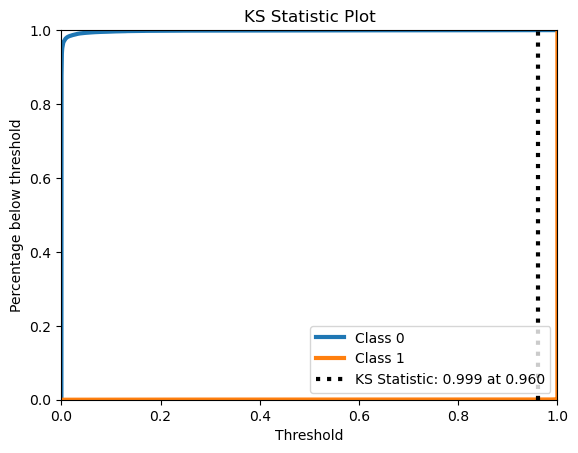

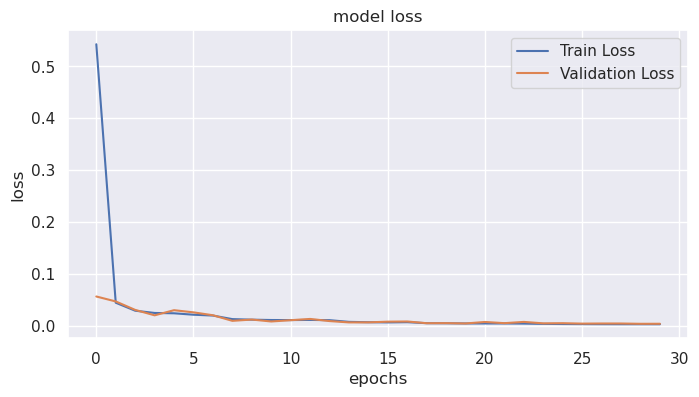

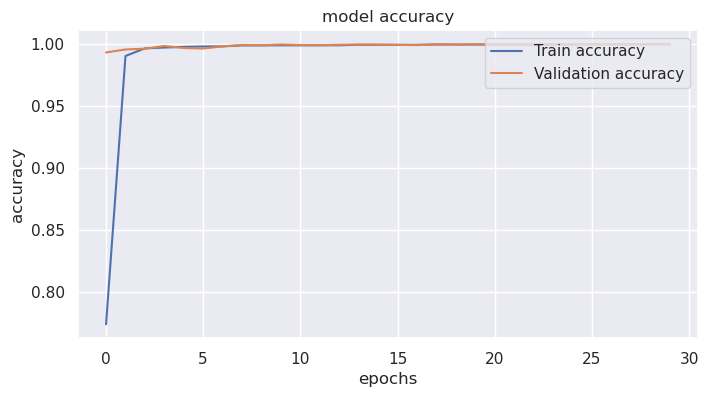

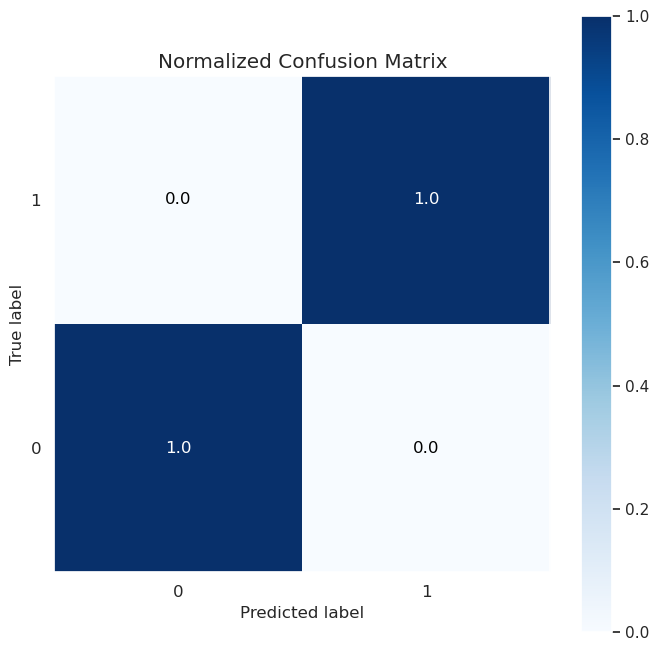

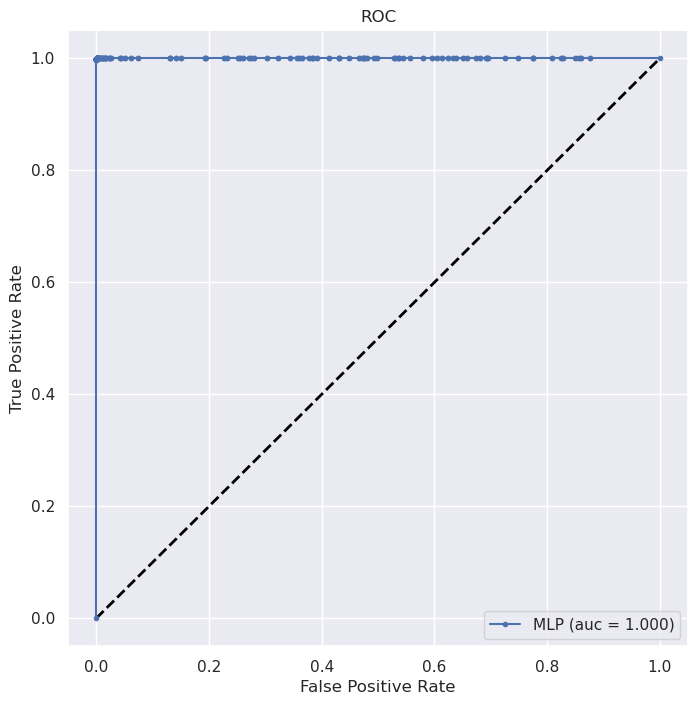

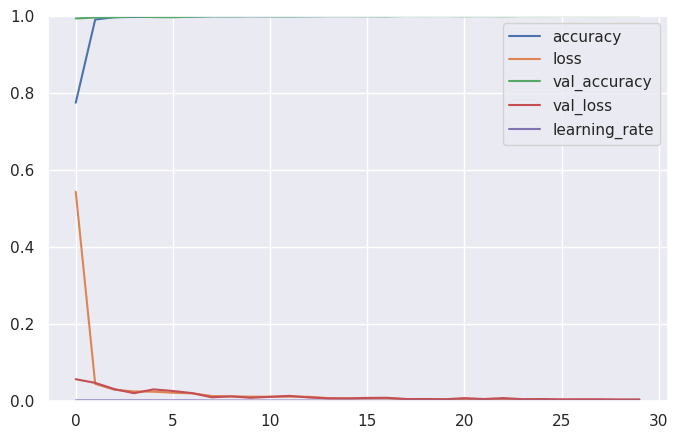

Objetos coletados: 0


/home/pedro/miniconda3/envs/DL_phd_py39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 44, 116, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 116, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,306,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,233 (5.19 MB)

 Trainable params: 1,359,041 (5.18 MB)

 Non-trainable params: 192 (768.00 B)

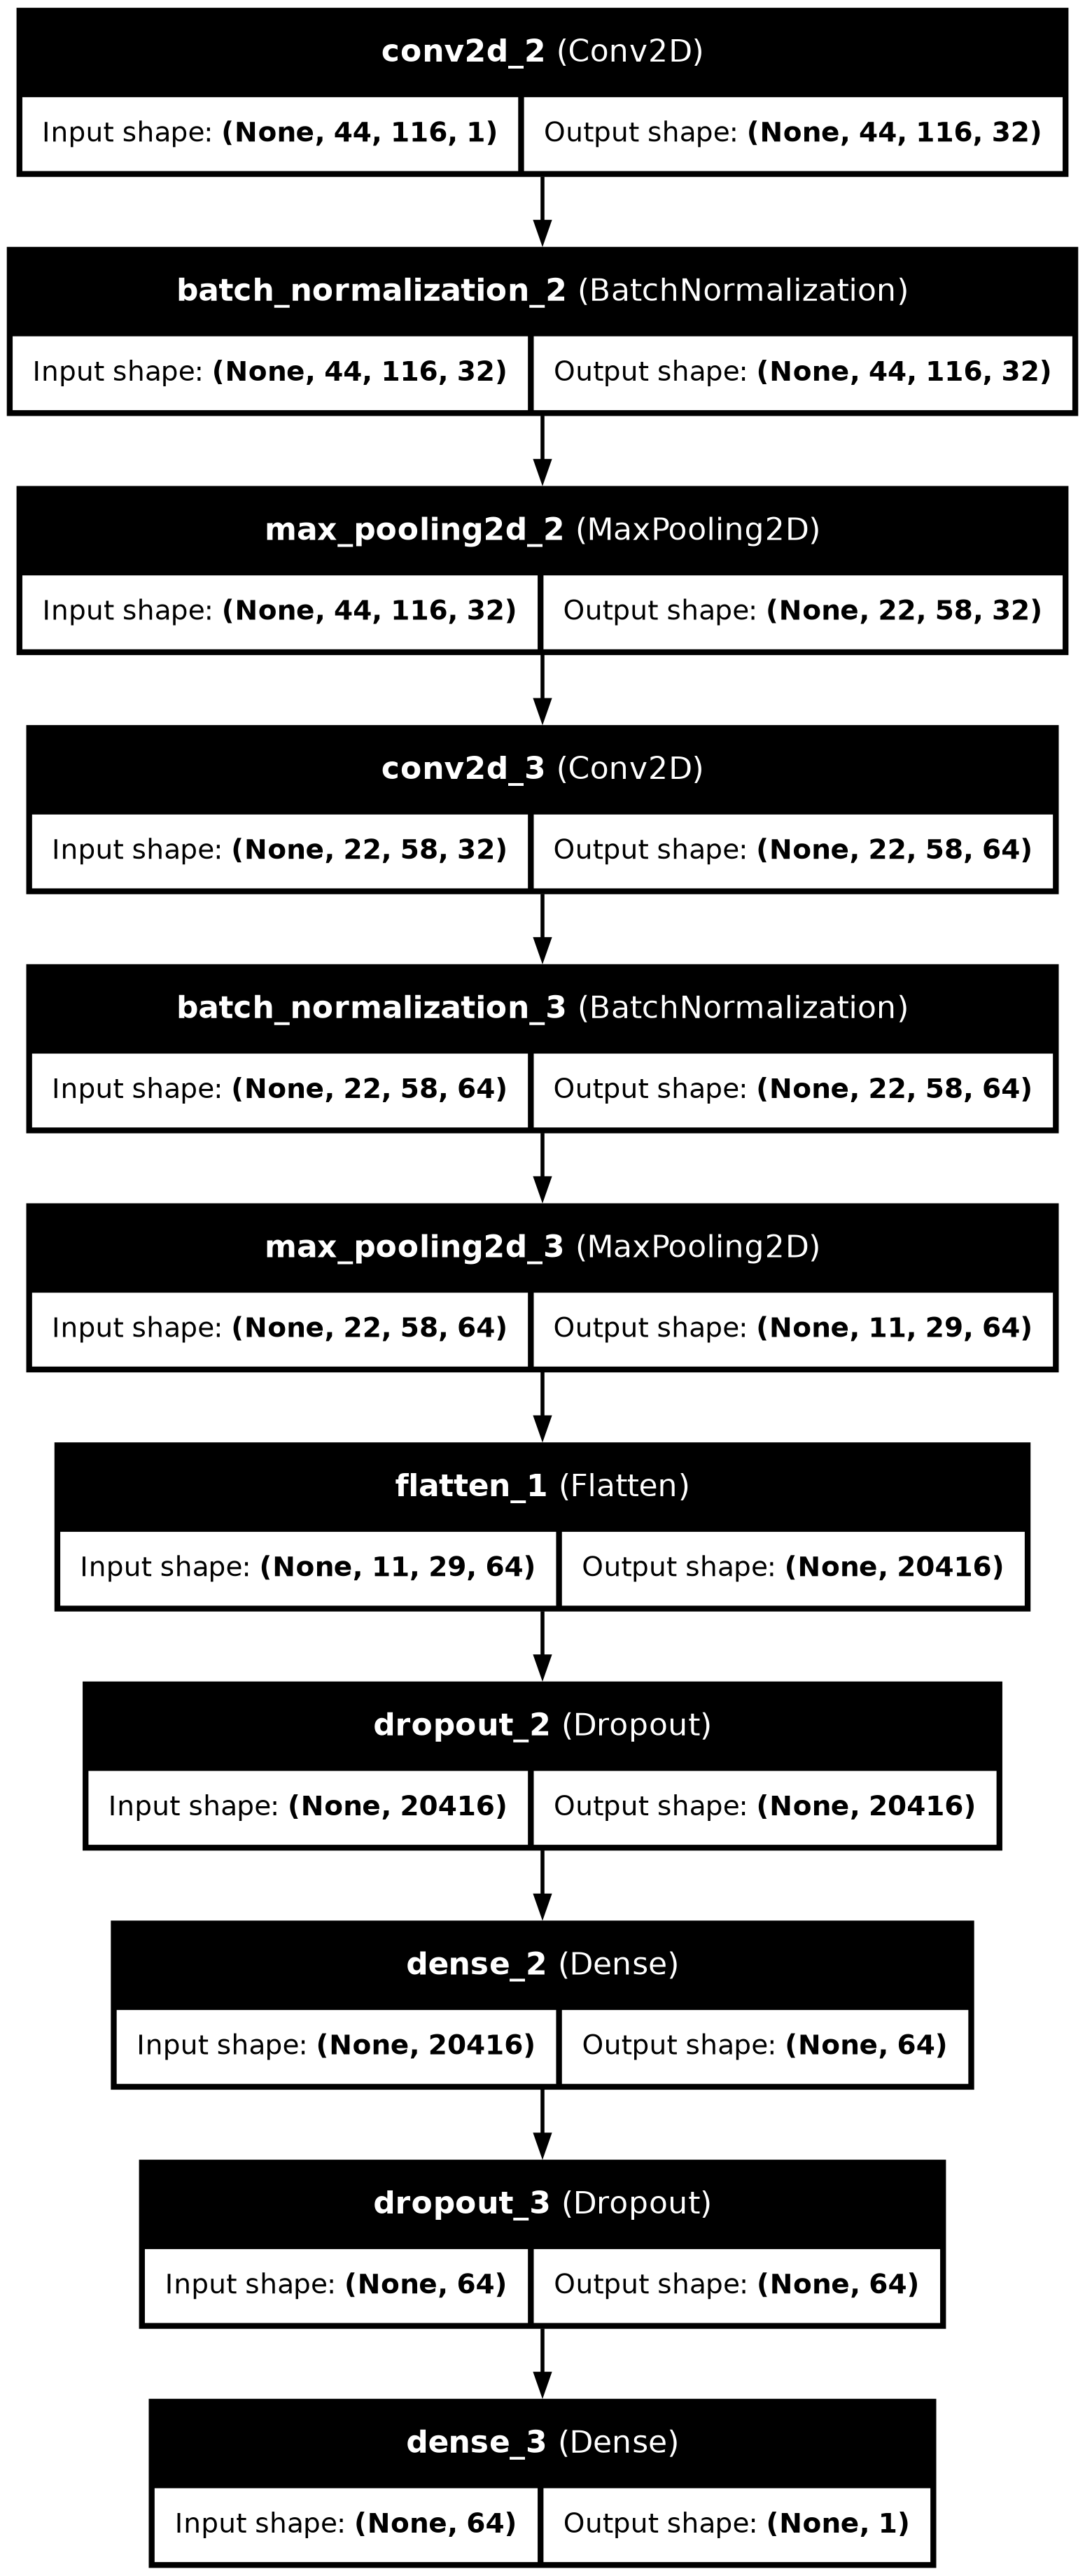

------------------------------------------------------------------------
Epoch 1/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - accuracy: 0.7607 - loss: 0.7984 - val_accuracy: 0.9915 - val_loss: 0.2798 - learning_rate: 0.0010
Epoch 2/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.7654 - loss: 0.3455 - val_accuracy: 0.6348 - val_loss: 0.3062 - learning_rate: 0.0010
Epoch 3/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.8772 - loss: 0.2350 - val_accuracy: 0.9847 - val_loss: 0.1837 - learning_rate: 0.0010
Epoch 4/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.9961 - loss: 0.0307 - val_accuracy: 0.9966 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 5/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.9972 - loss: 0.0242 - val_accuracy: 0.9966 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 6/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9974 - loss: 0.0233 - val_accuracy: 0.9883 - val_loss: 0.0754 - learning_rate

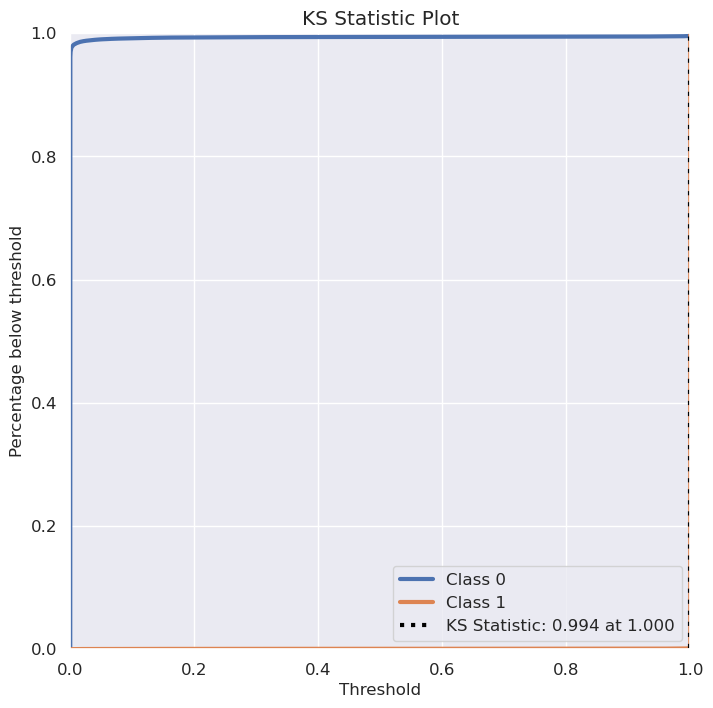

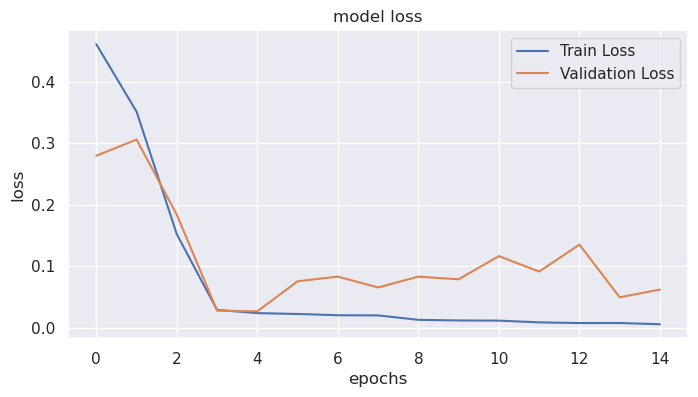

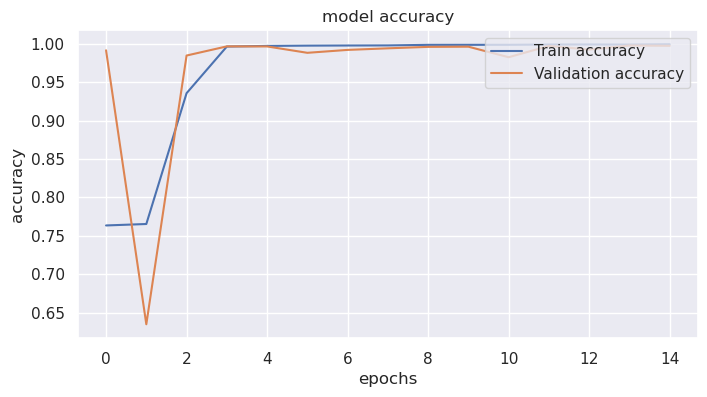

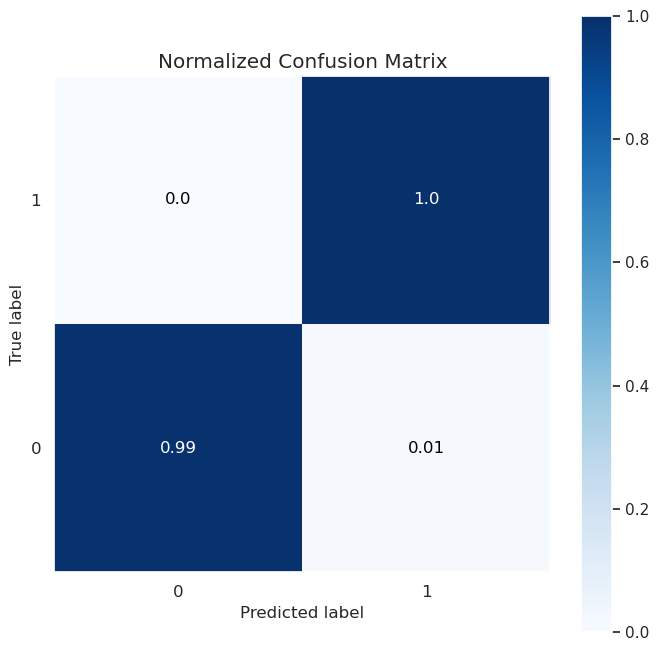

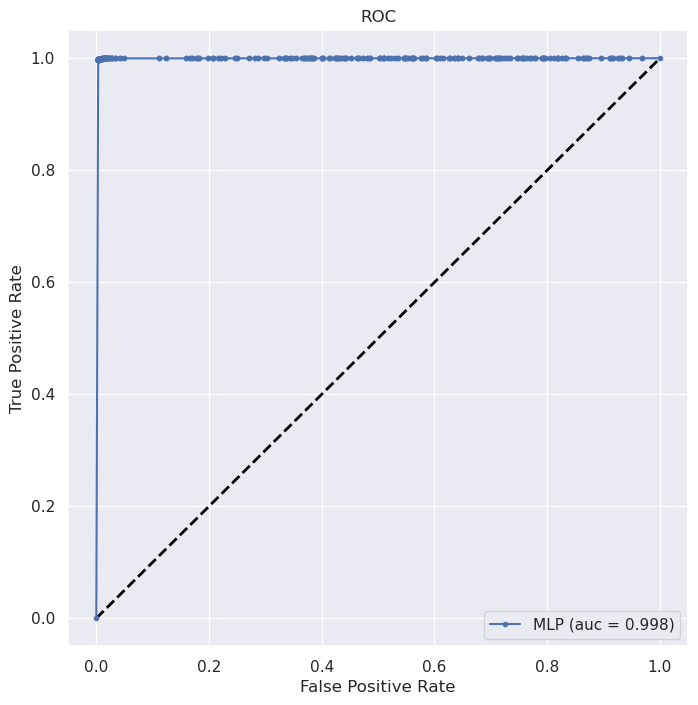

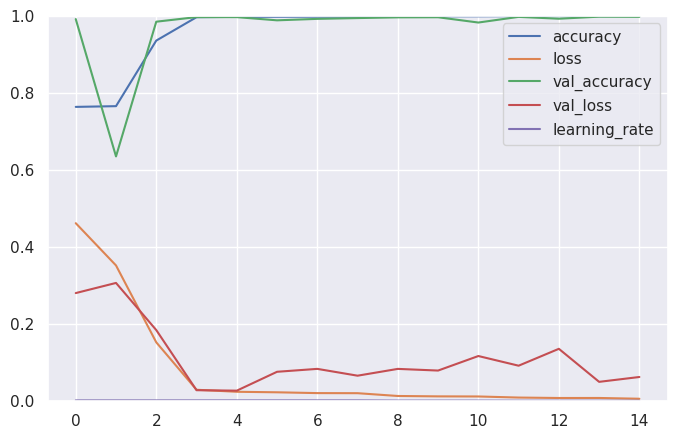

Objetos coletados: 0


/home/pedro/miniconda3/envs/DL_phd_py39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 44, 116, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 44, 116, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,306,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,233 (5.19 MB)

 Trainable params: 1,359,041 (5.18 MB)

 Non-trainable params: 192 (768.00 B)

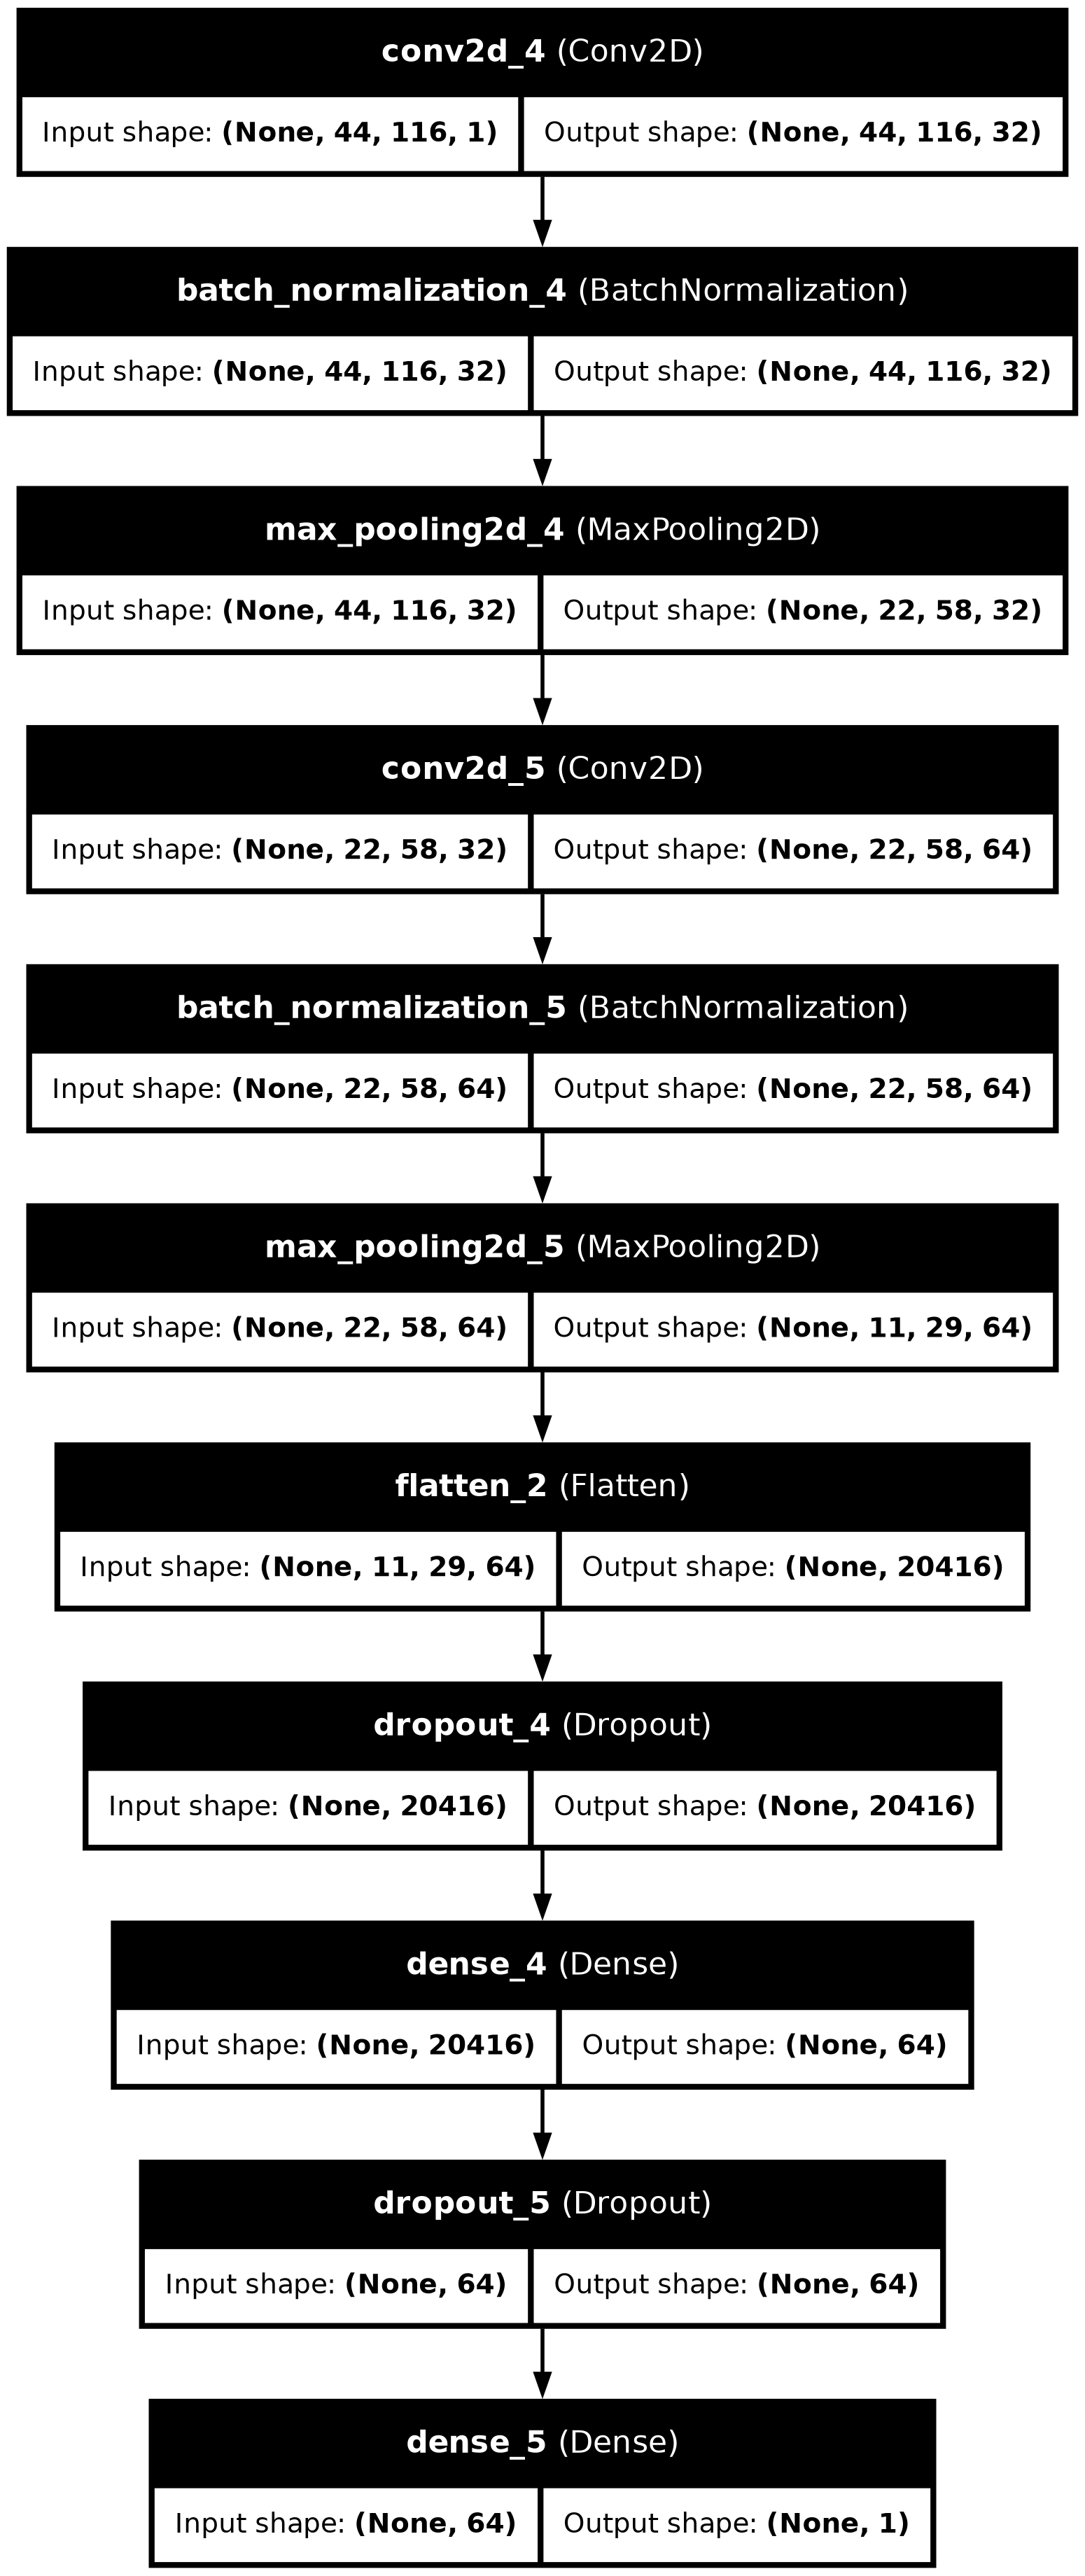

------------------------------------------------------------------------
Epoch 1/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.7365 - loss: 0.8423 - val_accuracy: 0.2559 - val_loss: 24.3647 - learning_rate: 0.0010
Epoch 2/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.7369 - loss: 0.6050 - val_accuracy: 0.4773 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 3/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - accuracy: 0.7370 - loss: 0.6972 - val_accuracy: 0.7436 - val_loss: 0.6298 - learning_rate: 0.0010
Epoch 4/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.7615 - loss: 0.5896 - val_accuracy: 0.8417 - val_loss: 0.4710 - learning_rate: 0.0010
Epoch 5/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - accuracy: 0.9731 - loss: 0.1326 - val_accuracy: 0.9959 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 6/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - accuracy: 0.9943 - loss: 0.0385 - val_accuracy: 0.9980 - val_loss: 0.0286 - learning_rat

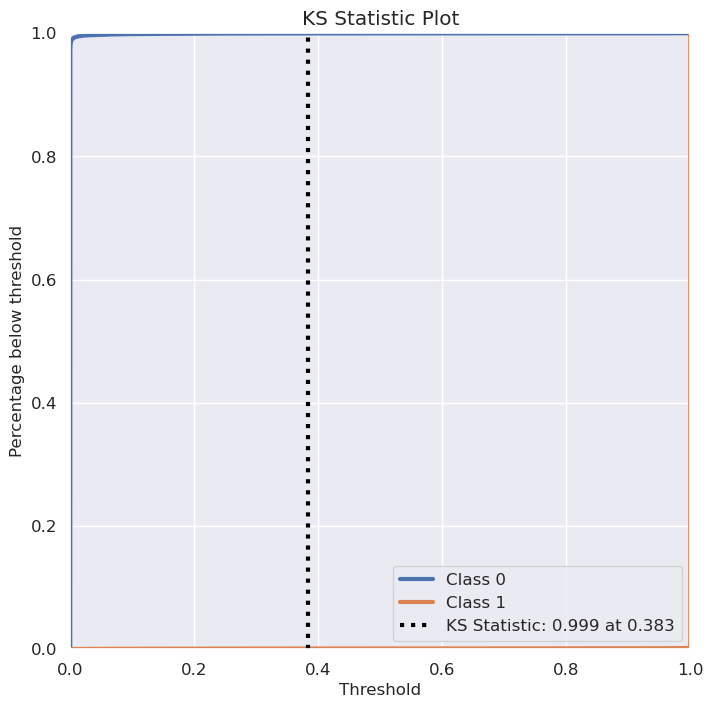

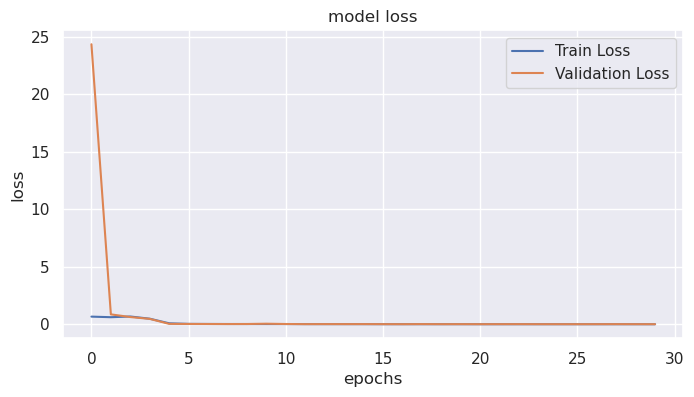

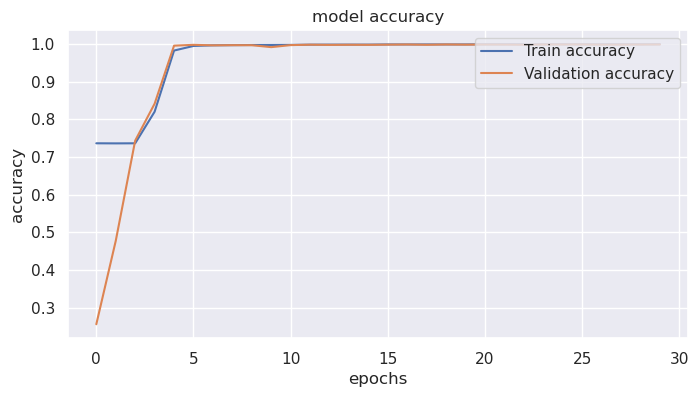

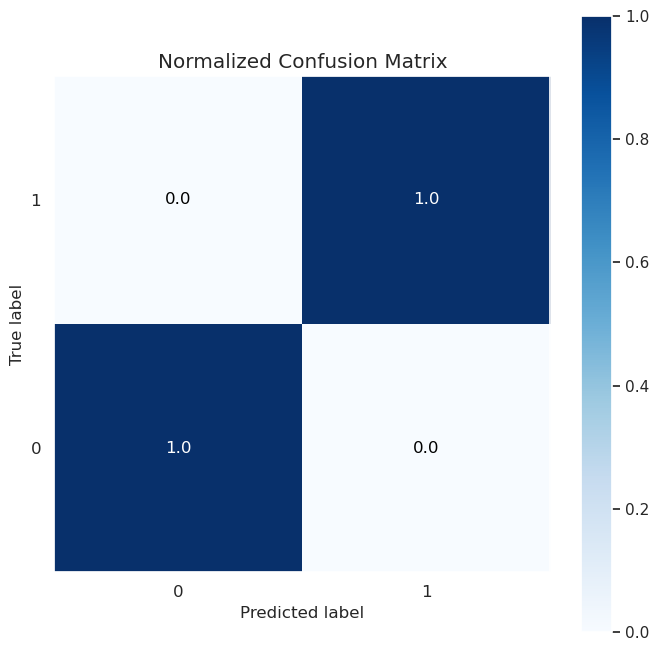

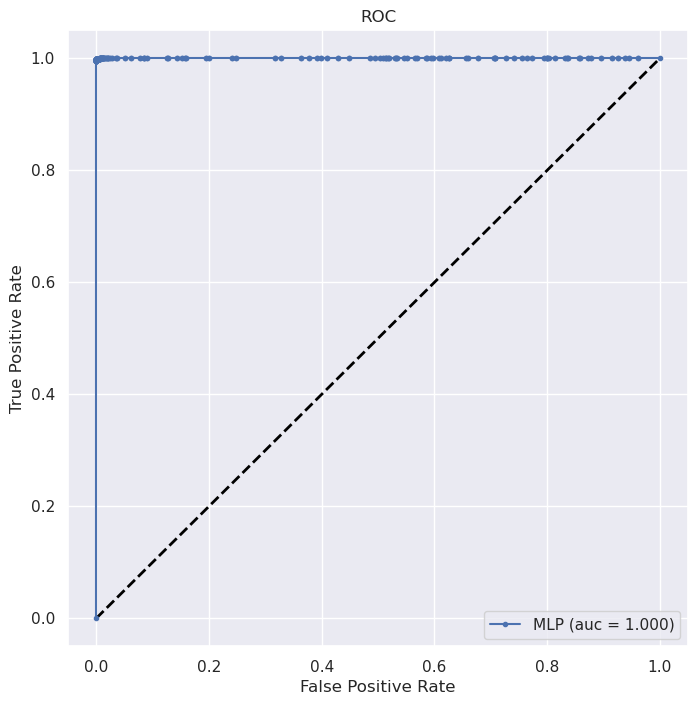

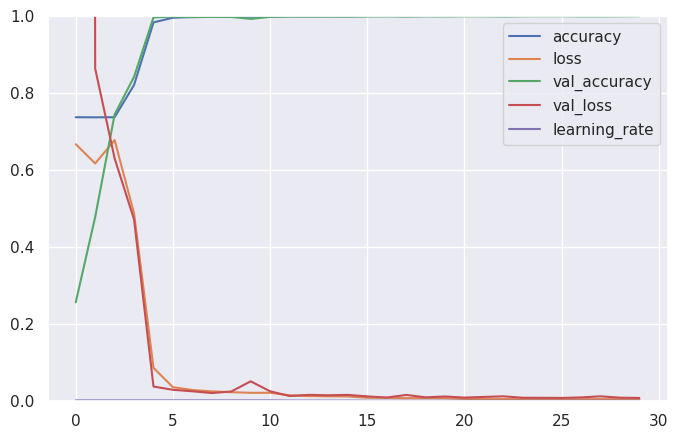

Objetos coletados: 0


/home/pedro/miniconda3/envs/DL_phd_py39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 44, 116, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 44, 116, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 22, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,306,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,233 (5.19 MB)

 Trainable params: 1,359,041 (5.18 MB)

 Non-trainable params: 192 (768.00 B)

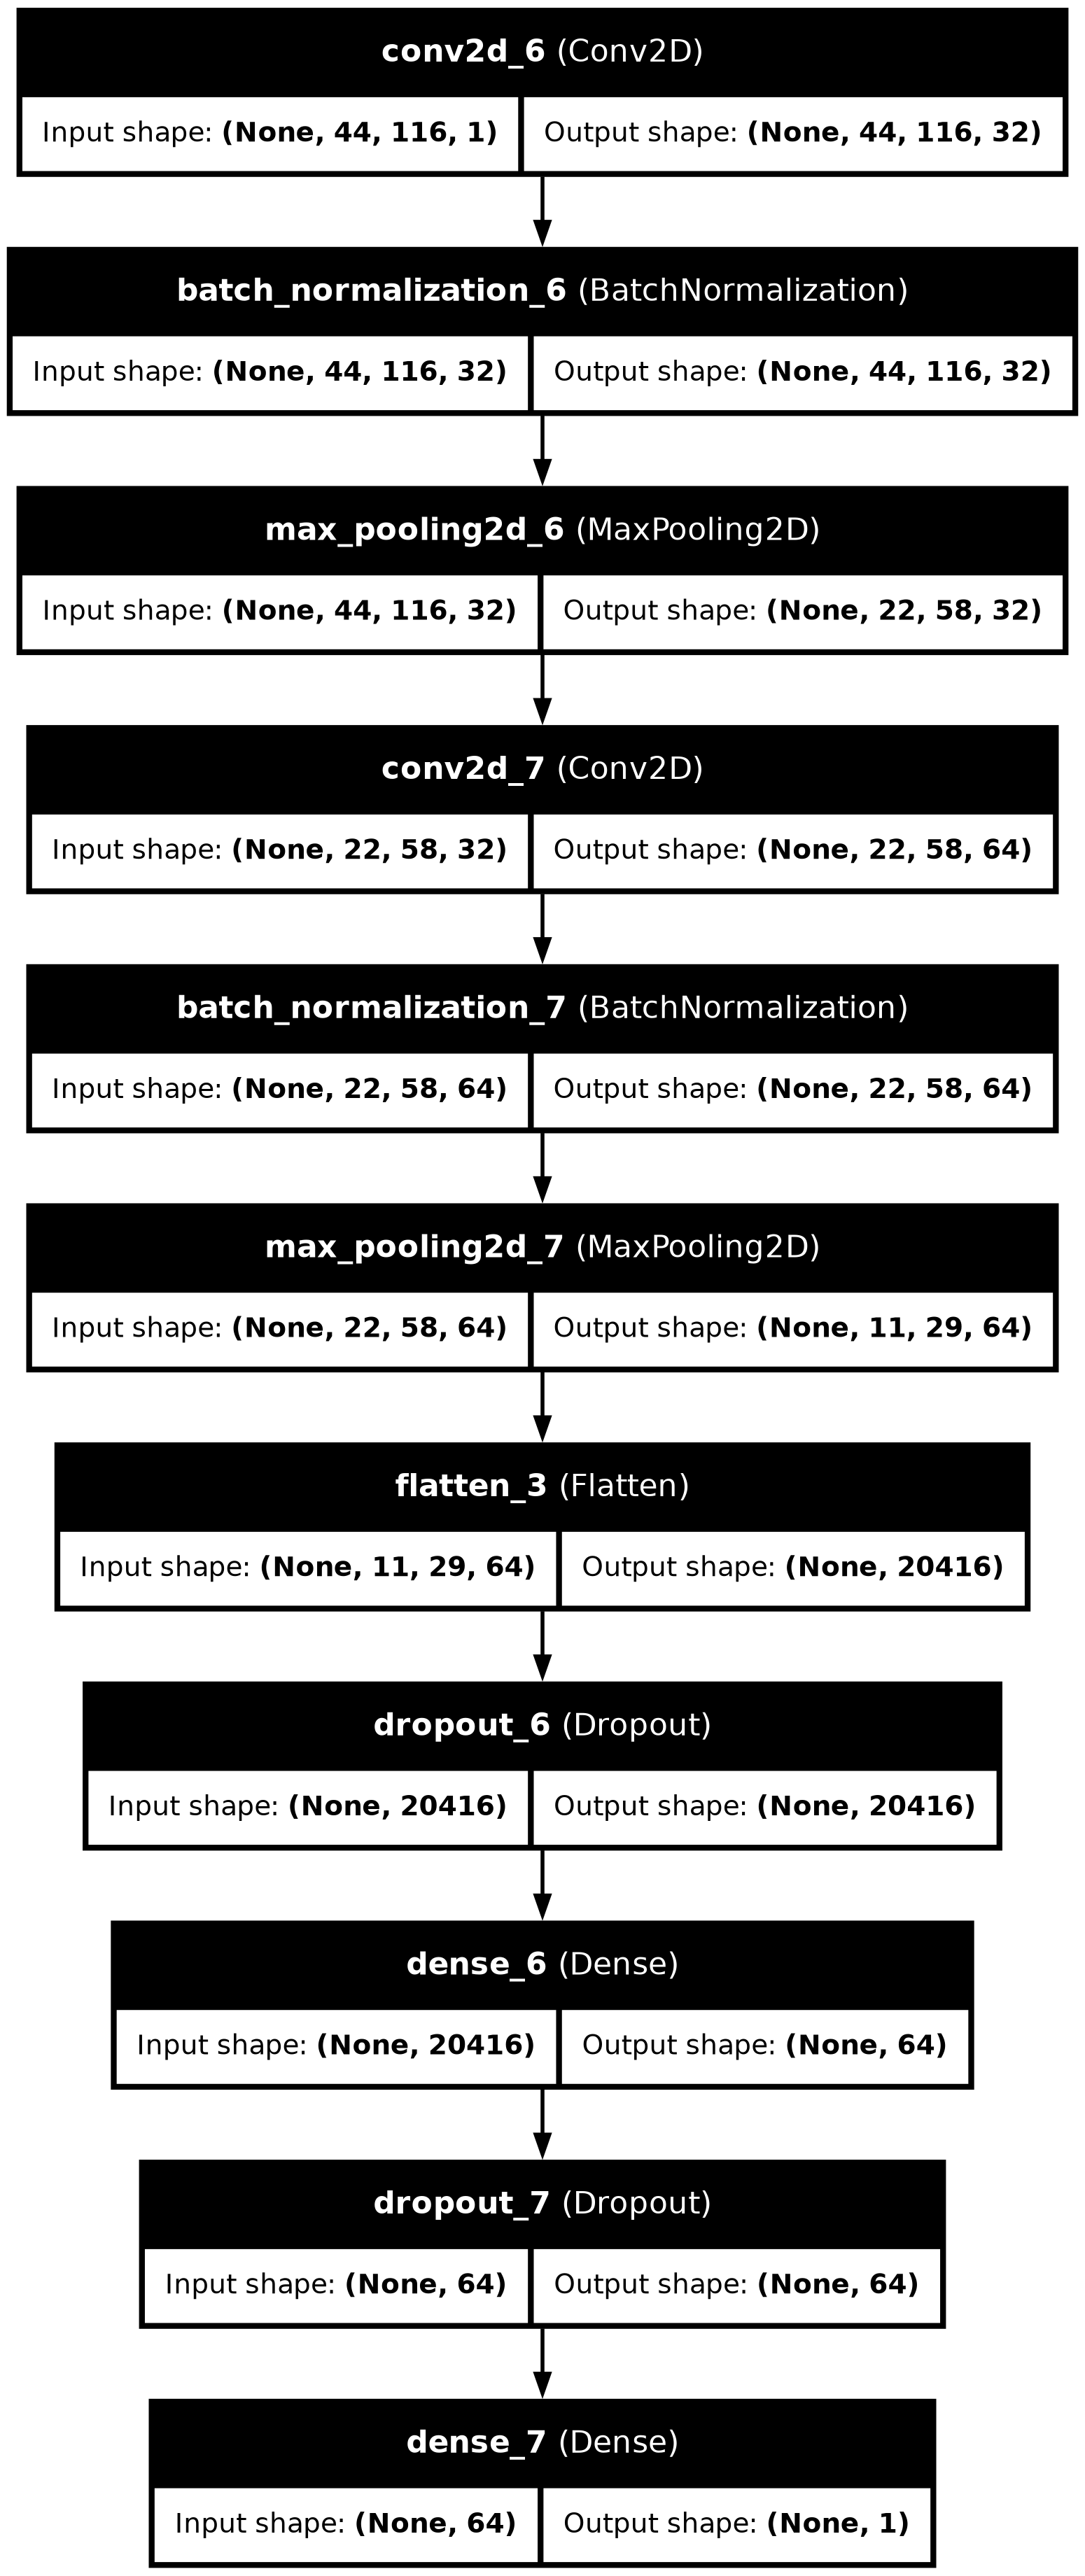

------------------------------------------------------------------------
Epoch 1/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 68s 33ms/step - accuracy: 0.7776 - loss: 0.6048 - val_accuracy: 0.9941 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 2/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - accuracy: 0.9934 - loss: 0.0703 - val_accuracy: 0.9971 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 3/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - accuracy: 0.9970 - loss: 0.0320 - val_accuracy: 0.9977 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 4/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.9975 - loss: 0.0273 - val_accuracy: 0.9986 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 5/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.9977 - loss: 0.0233 - val_accuracy: 0.9966 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 6/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.9976 - loss: 0.0228 - val_accuracy: 0.9981 - val_loss: 0.0173 - learning_rate

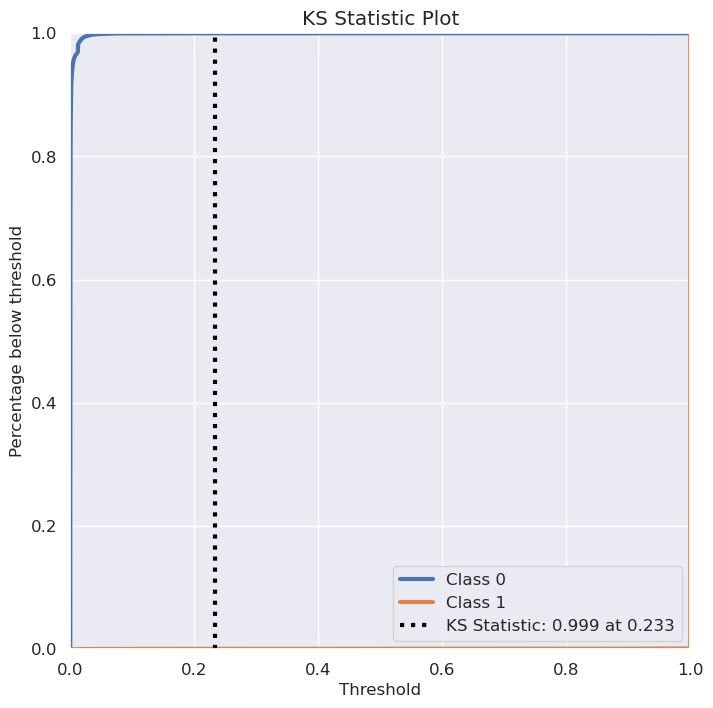

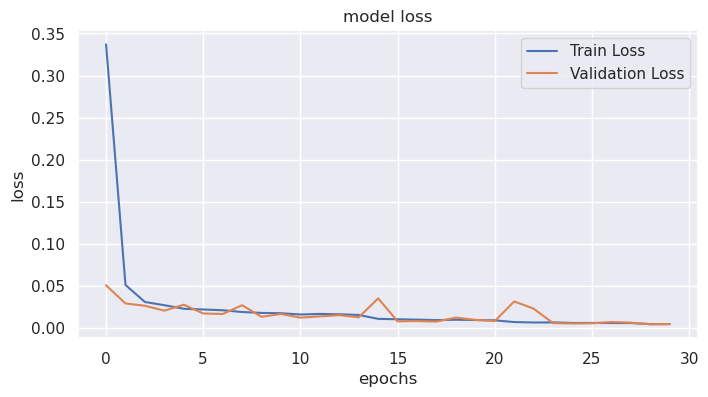

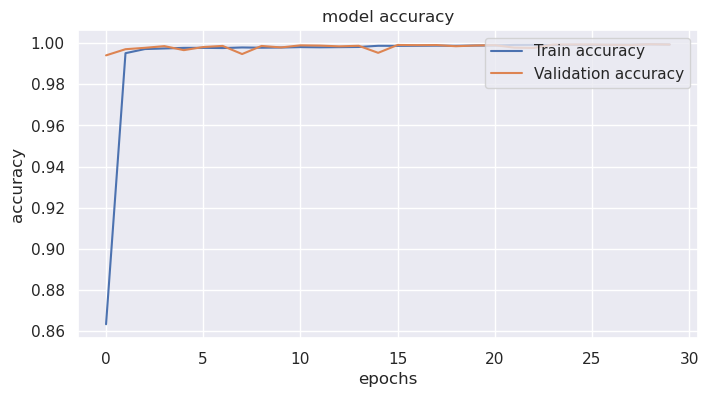

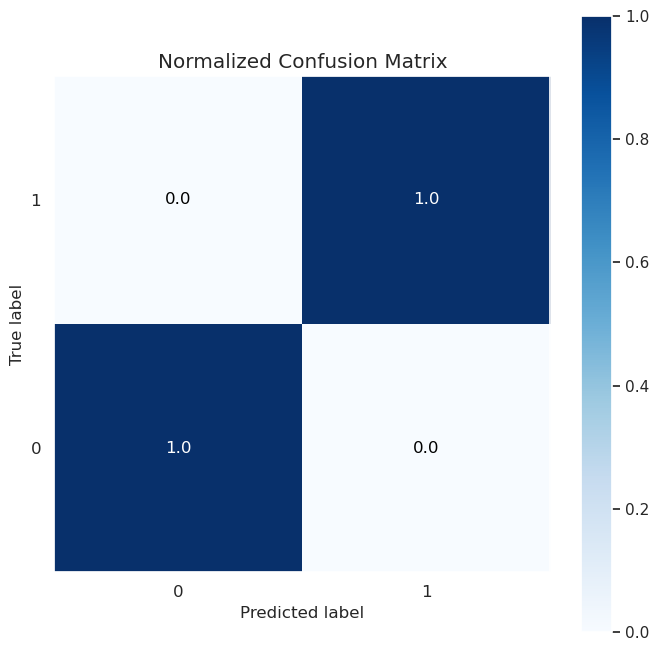

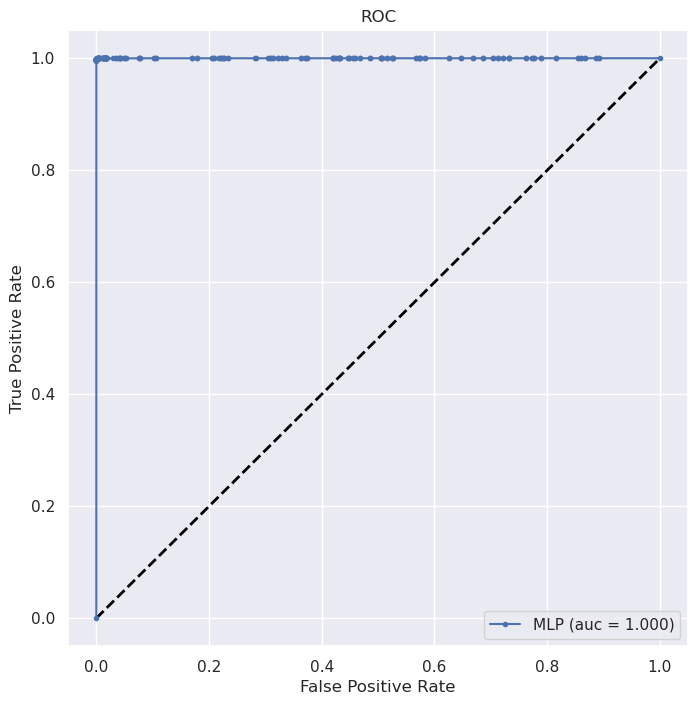

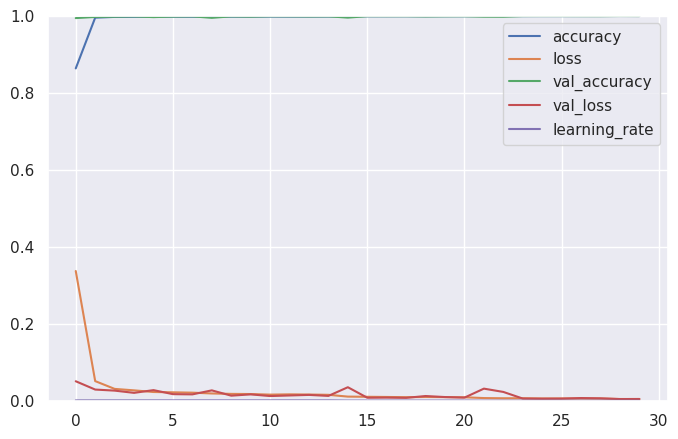

Objetos coletados: 0


/home/pedro/miniconda3/envs/DL_phd_py39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 44, 116, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 44, 116, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 22, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 11, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,306,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,233 (5.19 MB)

 Trainable params: 1,359,041 (5.18 MB)

 Non-trainable params: 192 (768.00 B)

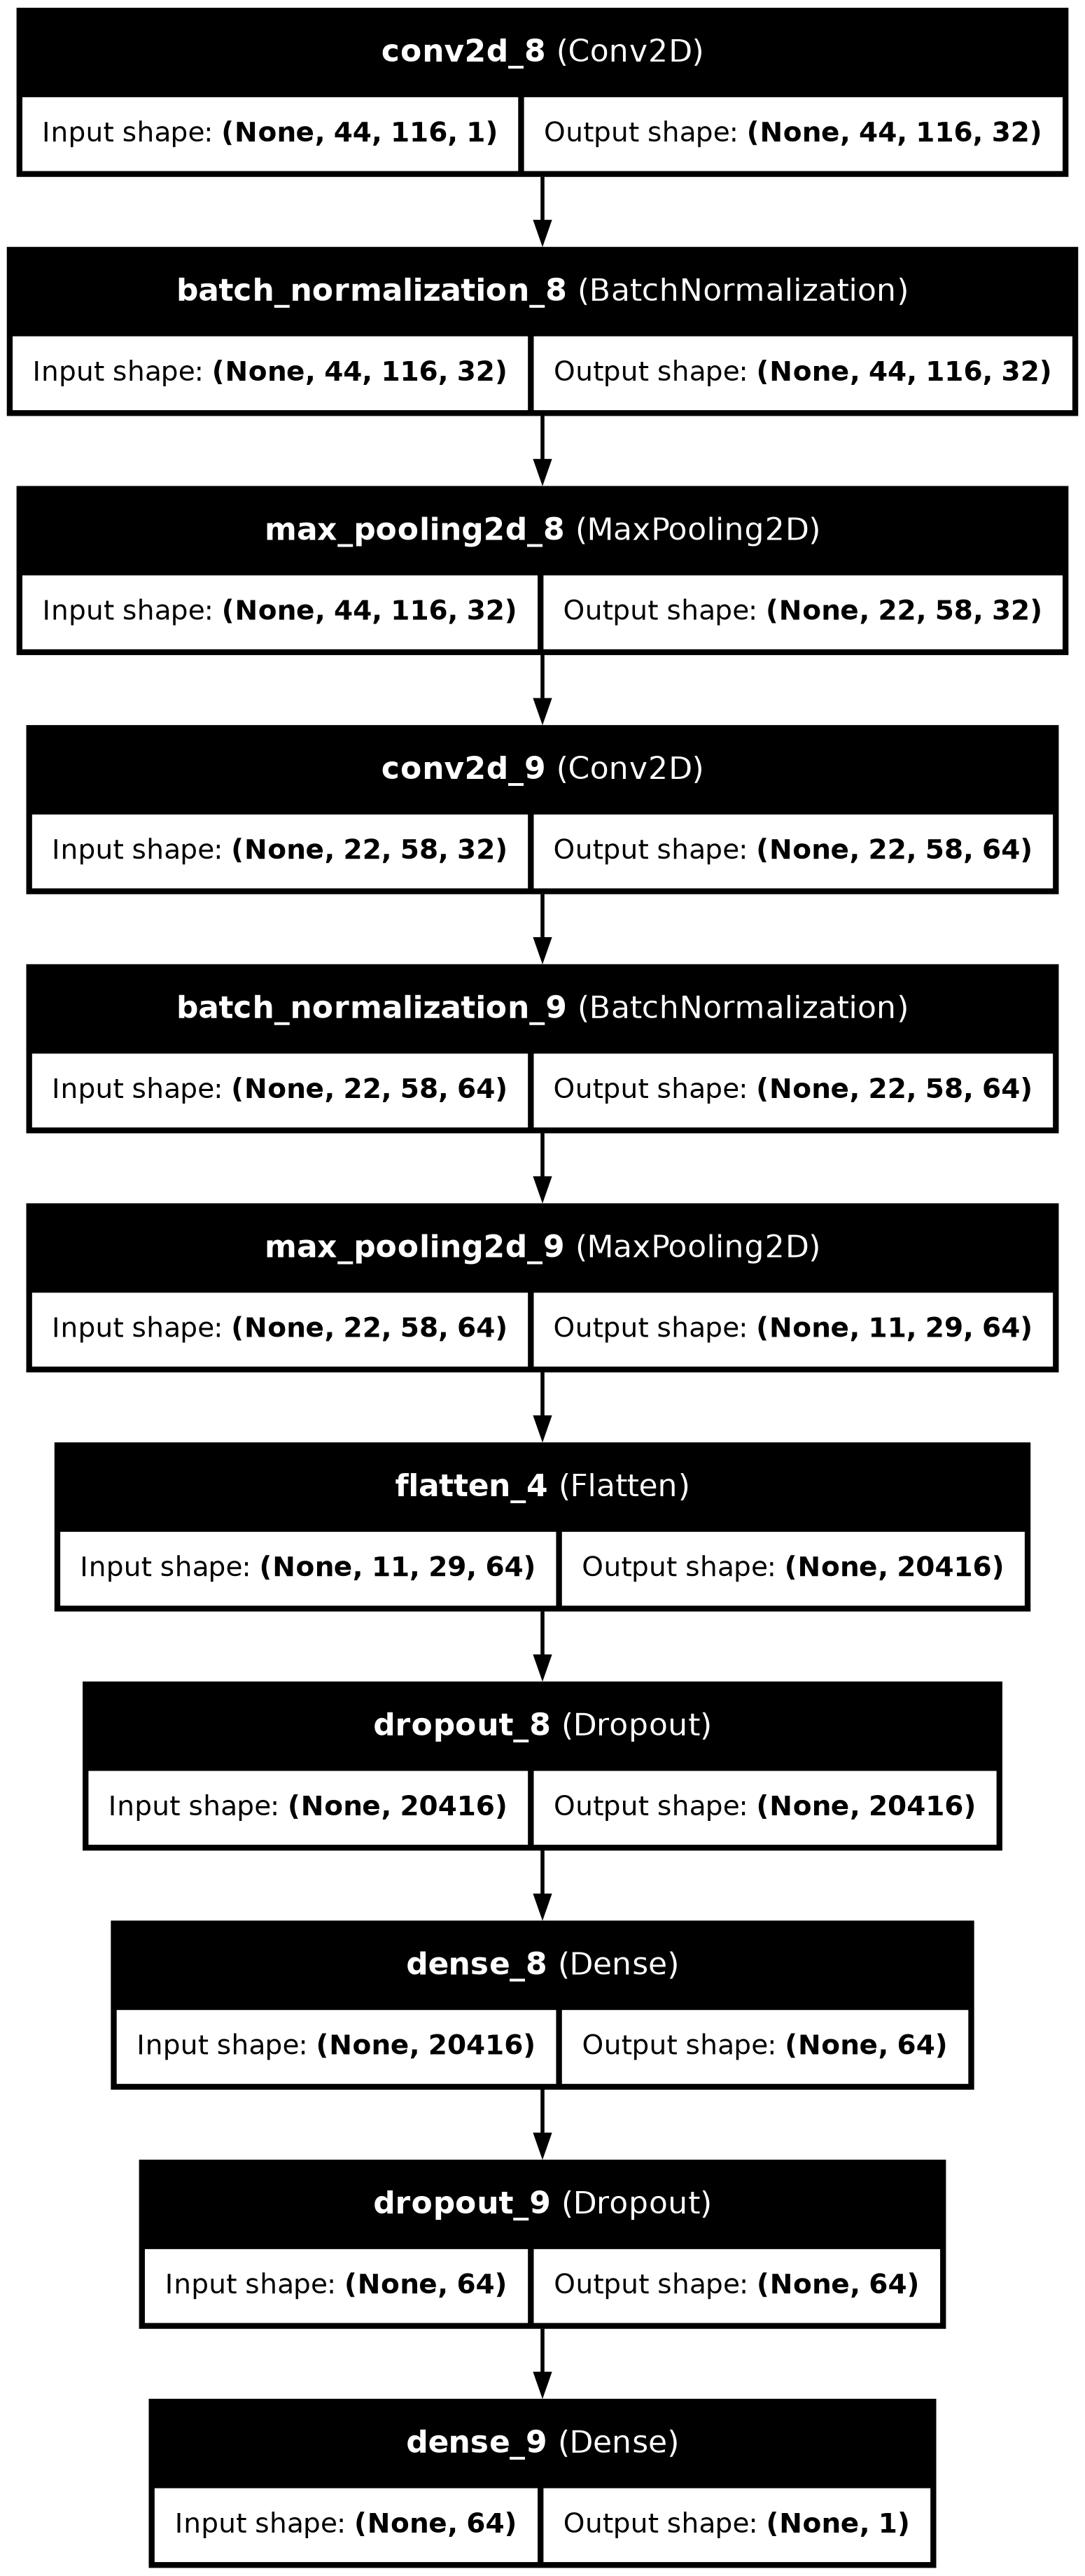

------------------------------------------------------------------------
Epoch 1/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.8668 - loss: 0.5130 - val_accuracy: 0.9958 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 2/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - accuracy: 0.9967 - loss: 0.0405 - val_accuracy: 0.9958 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 3/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.9972 - loss: 0.0291 - val_accuracy: 0.9988 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 4/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.9979 - loss: 0.0211 - val_accuracy: 0.9977 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 5/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9976 - loss: 0.0225 - val_accuracy: 0.9988 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 6/30
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - accuracy: 0.9979 - loss: 0.0202 - val_accuracy: 0.9984 - val_loss: 0.0159 - learning_rate

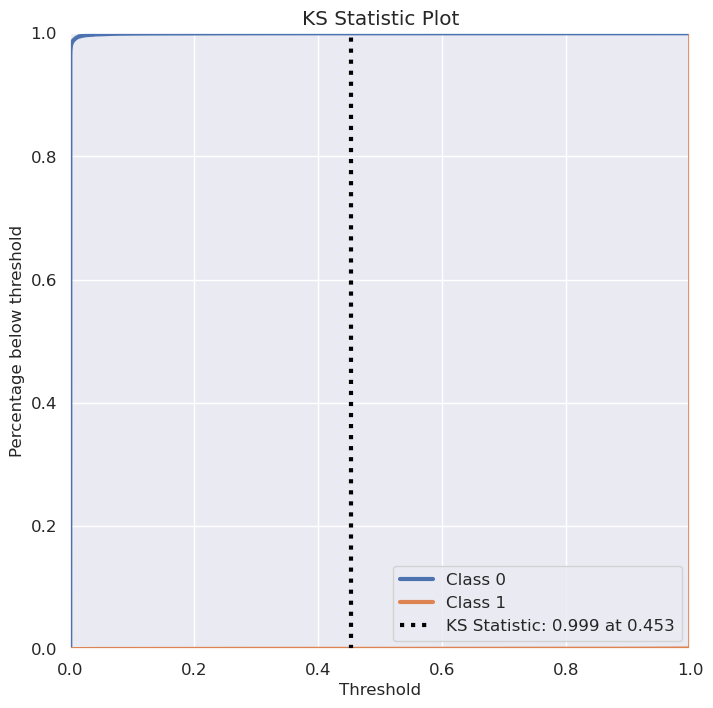

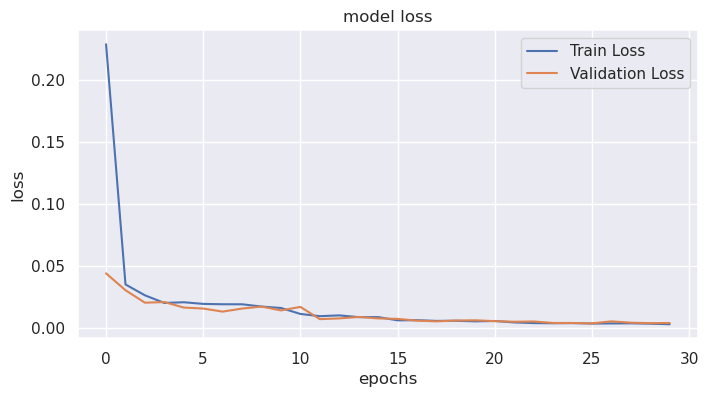

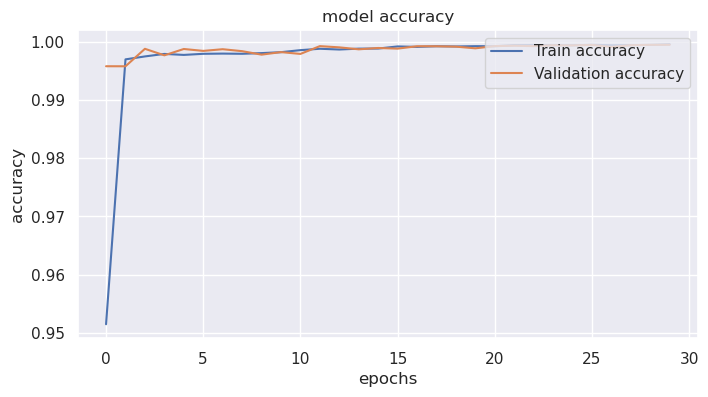

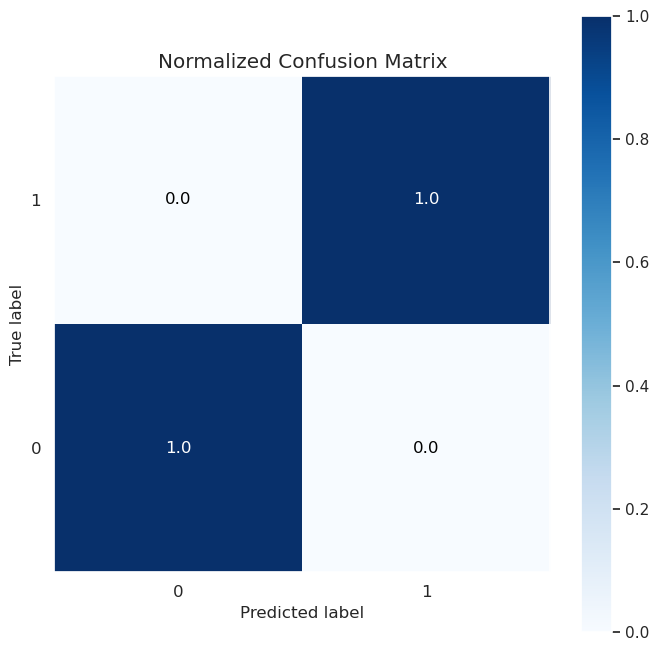

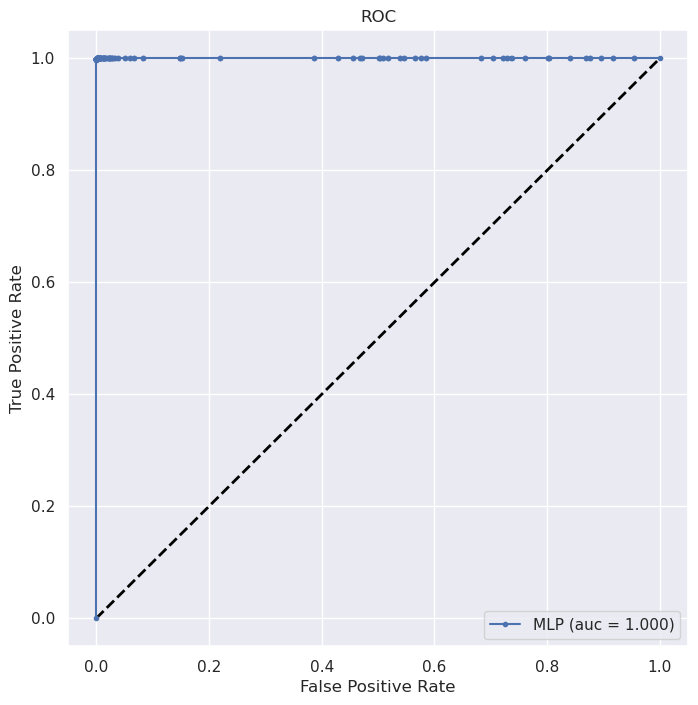

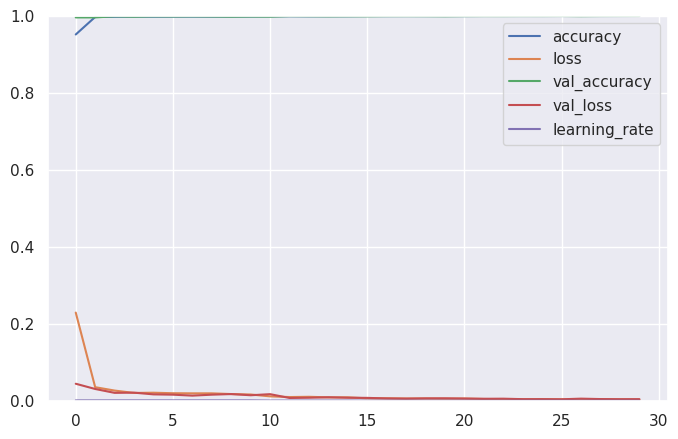

Objetos coletados: 0


In [8]:
import tensorflow as tf
from tensorflow import keras
# import numpy as np

import matplotlib.pyplot as plt
import sklearn
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

from keras import regularizers

# from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import gc
import time
import sys
import datetime
import os

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

tmp_path = log_path

#CRIANDO A REDE CONV

skf = KFold(n_splits=5)

fold_no = 0

for train_index, val_index in skf.split(X, Y):
  fold_no += 1
  # Criando o diretório para salvar os arquivos
  save_path = os.path.join(tmp_path, f"{fold_no}_fold")
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  # Criando o arquivo de log
  file_name = f'fold{fold_no}_log_{timestamp}.txt'
  file1 = open(os.path.join(save_path, file_name), "a")

  if True:
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]

    print(f'Train: {np.unique(y_train, return_counts=True)}', file=file1)

    print(f'Val: {np.unique(y_val, return_counts=True)}', file=file1)

    gc.collect()

    model = keras.models.Sequential()
    #1
    model.add(Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu',
                     kernel_regularizer=regularizers.l2(0.01), padding='same', input_shape=(44, 116, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    #2
    model.add(Conv2D(filters=64, kernel_size=5, strides=(1, 1), activation='relu',
                     kernel_regularizer=regularizers.l2(0.01), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    # #flatten
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    print(model.summary(), file=file1)

    plot_model(model, to_file="conv2d.png", show_shapes=True, show_layer_names=True)
    display(Image(filename='conv2d.png'))


    #
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=["accuracy"])

    # reduz o parâmetro de learning rate se não houver
    # melhoras em determinado número de epocas
    # útil para encontrar o mínimo global.
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=3,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...', file=file1)

    #Treinando a Rede Neural definida utilizando 30 épocas
    # history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), batch_size=64,
    #                     verbose=1, shuffle=False)

    batch_size = 256
    history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), batch_size=batch_size,
                          # callbacks=[early_stopping], verbose=1, shuffle=True)
                          callbacks=[learning_rate_reduction, early_stopping], verbose=1, shuffle=True)

    # Generate generalization metrics
    # scores = model.evaluate(x_val, y_val, verbose=0)
    # y_pred_scores = model.predict(x_val)
    # y_pred_class=np.argmax(y_pred_scores,axis=1)

    # accuracy, recall, precision, f1, auroc, aupr, ks = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)
    # mseTeste = mean_squared_error(y_val, y_pred_class)

    # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    # print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}')

    # acc_per_fold.append(scores[1] * 100)
    # loss_per_fold.append(scores[0])

    #########################################################################################################

    y_pred_scores = model.predict(x_val)
    y_pred_class = (y_pred_scores > 0.5).astype("int64")

    y_pred_scores2 = y_pred_scores
    y_pred_scores_0 = 1 - y_pred_scores
    y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)

    # Salvar na pasta de log os valores de y_val e y_pred_class e y_pred_scores
    np.savez_compressed(os.path.join(save_path, f"fold_{fold_no}_y_val_y_pred_class_y_pred_scores.npz"), y_val=y_val, y_pred_class=y_pred_class, y_pred_scores=y_pred_scores)

    mseTeste = mean_squared_error(y_val, y_pred_class)

    print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

    sns.set(rc={'figure.figsize':(8,8)})
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(save_path + "loss_and_val_loss.png")
    plt.show()

    sns.set(rc={'figure.figsize':(8,8)})
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(save_path + "loss_and_val_accuracy.png")
    plt.show()

    sns.set(rc={'figure.figsize':(8,8)})
    subplot = skplt.metrics.plot_confusion_matrix(y_val, y_pred_class, normalize=True)
    subplot.set_ylim(-0.5, 1.5)
    plt.savefig(save_path + "conf_matrix.png")
    plt.show()

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
    auc_keras = auc(fpr_keras, tpr_keras)


    sns.set(rc={'figure.figsize':(8,8)})
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig(save_path + "plot_roc.png")
    plt.show()
    #########################################################################################################
    #Plotando o histórico do treino
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

    model_name = 'fold_n_' + str(fold_no) + '_2dconv_fixed.h5'
    model.save(save_path + model_name)

    file1.close()

    # Deletar as variáveis
    del x_train, x_val, y_train, y_val, model, history, y_pred_scores, y_pred_class, y_pred_scores2, y_pred_scores_0

    # Forçar a coleta de lixo
    gc.collect()

    # Pausar para garantir que a coleta de lixo seja concluída
    time.sleep(5)

    # Forçar a coleta de lixo novamente para garantir que toda a memória possível seja liberada
    gc.collect()

    # Verificar a quantidade de objetos coletados
    print(f"Objetos coletados: {gc.collect()}")
  else:
    pass


In [10]:
print("Test finished.")
print("Summary of results:")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc_keras}")
print(f"AUPR: {aupr}")
print(f"AUROC: {auroc}")
print(f"F1 Score: {f1}")
print(f"MSE: {mseTeste}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Test finished.
Summary of results:
Accuracy: 0.9994870240399188
AUC: 0.9999805104542264
AUPR: 0.999995873916495
AUROC: 0.9999805104542264
F1 Score: 0.9996853066829418
MSE: 0.0005129759600811434
Precision: 1.0
Recall: 0.9993708113673413
